In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import colormaps
from pathlib import Path
import rerun as rr
from b3d.utils import keysplit


key = jax.random.PRNGKey(0)

In [4]:
from b3d.chisight.sfm.datasets import TumRgbdData


root = Path("/home/mirko/workspace/data/rgbd_slam_dataset_freiburg")
datasets = TumRgbdData._show_available_datasets(root)

Available datasets in /home/mirko/workspace/data/rgbd_slam_dataset_freiburg/...:
(0) rgbd_dataset_freiburg2_desk_with_person
(1) rgbd_dataset_freiburg3_walking_xyz
(2) rgbd_dataset_freiburg2_desk
(3) rgbd_dataset_freiburg1_xyz
(4) rgbd_dataset_freiburg3_walking_static
(5) rgbd_dataset_freiburg1_room
(6) rgbd_dataset_freiburg3_walking_rpy


In [5]:
sequence_name = "rgbd_dataset_freiburg3_walking_xyz"
sequence_url = TumRgbdData._sequence_url_from_sequence_name(sequence_name)
sequence_folder = TumRgbdData._download_from_url(sequence_url, root)

Sequence rgbd_dataset_freiburg3_walking_xyz already exists.


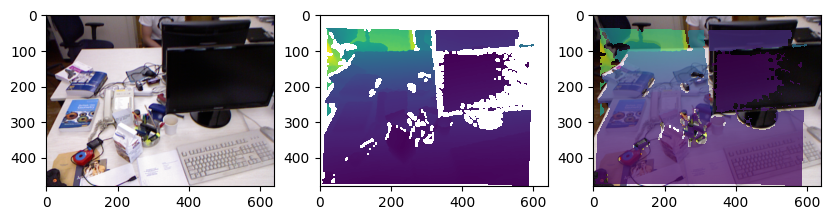

In [9]:
sequence_name = "rgbd_dataset_freiburg1_xyz"
path = root/sequence_name
data = TumRgbdData(path)

# Get the i'th RGB image
# Note that rgb, depth, and pose sequences are not synchronized, so the i'th RGB image
# and the i'th depth image and pose are not guaranteed to be from the same time.
i = 100
rgb = data.get_rgb(i)

# This returns i'th RGB image and the CLOSEST (in time) available depth image and pose
rgb, depth, pose = data.get_synced(i)
# ==============================================
# Plot the RGB and depth images side by side
fig, axs = plt.subplots(1, 3, figsize=(10,5))
axs[0].imshow(rgb)
axs[1].imshow(np.where(depth>0, depth, np.nan))
axs[2].imshow(rgb, alpha=1.)
axs[2].imshow(np.where(depth>0, depth, np.nan), alpha=0.75);

In [8]:
# Look at the 3D Points in rerun
xs, cs, _ = data._get_colored_world_points(i)
# =============
rr.init("SfM")
rr.connect("127.0.0.1:8812")
rr.set_time_sequence("frame_idx", 0)
rr.log(f"3DPoints", rr.Points3D(xs, colors=cs,radii=.01))

# Keypoints

In [12]:
from b3d.chisight.sfm.plotting_utils import log_pose

In [13]:
import cv2
from b3d.types import Float
from functools import partial


def cos_distance(f1: Float, f2: Float) -> Float:
    """Compute the angular distance between SIFT or other Descriptors."""
    norms = jnp.linalg.norm(f1) * jnp.linalg.norm(f2)
    return jnp.acos(jnp.minimum(jnp.dot(f1, f2) / norms, 1.0))


@partial(jax.jit, static_argnums=1)
def knn(X, k):
  distance_matrix = jnp.sum((X[:, None, :] - X[None, :, :]) ** 2, axis=-1)
  I = jnp.argsort(distance_matrix, axis=-1)[:, :k]
  return I

In [14]:
data.shape

(798, 480, 640)

In [49]:
data.name

'rgbd_dataset_freiburg1_xyz'

Quat diff: 0.0777


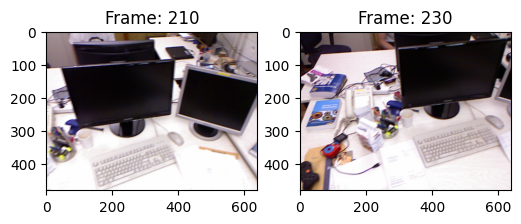

In [50]:
t0 = 210
dt = 20
t1 = t0 + dt

good_examples = {
    'rgbd_dataset_freiburg1_xyz': [
        (110,130)
    ]
}
bad_examples = {
    "rgbd_dataset_freiburg1_room": [(100, 110), (120,140), (410,430), (1110,1130)]
}

rgb, depth, cams = data[[t0,t1]]

# ==============================================
print(f"Quat diff: {jnp.linalg.norm(cams[0].quat - cams[1].quat):0.4f}")
data.plot_multiple_frames([t0,t1], axs=None);

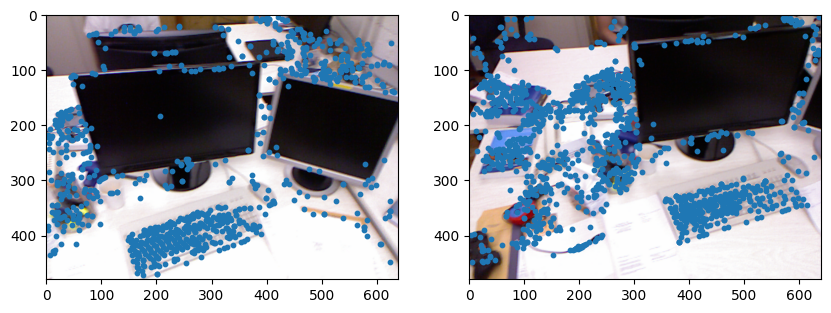

In [104]:
# feature_obj = cv2.ORB_create()
feature_obj = cv2.SIFT_create()


ks0, fs0 = feature_obj.detectAndCompute(cv2.cvtColor(rgb[0],  cv2.COLOR_RGB2BGR), None)
uv0 = np.array([k.pt for k in ks0])
r0 = np.array([k.angle for k in ks0])

ks1, fs1 = feature_obj.detectAndCompute(cv2.cvtColor(rgb[1],  cv2.COLOR_RGB2BGR), None)
uv1 = np.array([k.pt for k in ks1])
r1 = np.array([k.angle for k in ks1])


fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(rgb[0])
axs[0].scatter(uv0[:,0], uv0[:,1], s=10)

axs[1].imshow(rgb[1])
axs[1].scatter(uv1[:,0], uv1[:,1], s=10)

20
149.95667 41.12177 430.95938 264.07126


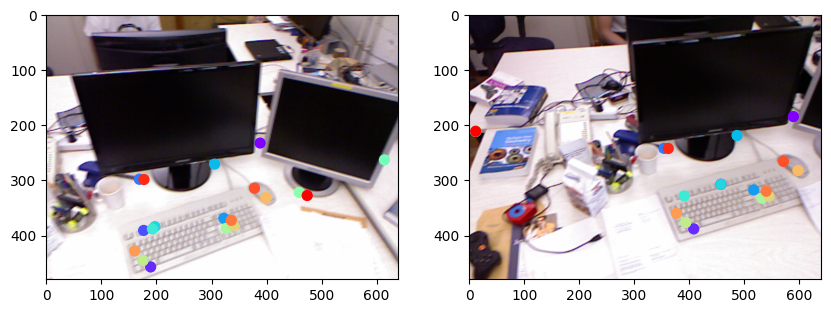

In [105]:
def _nngap(x, Y):
    """"
    Compute the nearest neighbor gap between x and Y
    """
    ds = jnp.linalg.norm(x[None] - Y, axis=-1)
    i, j = jnp.argsort(ds)[:2]
    return ds[j] - ds[i], ds[i], i

nngap = jax.vmap(_nngap, in_axes=(0, None))

# Compute the gap between keypoint features and 
# only keep keypoints with the largest gap. 
# That means they are somewhat unique
g, d, i = nngap(fs0, fs1)
i0s = jnp.argsort(g )[-20:]
# i0s = jnp.argsort(d )[:40]
# i0s = np.random.choice(i0s, 8, replace=False)
i1s = i[i0s]

print(len(i0s))
print(jnp.sort(d)[100], d.min(), d.max(), d.mean())

# ==================
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(rgb[0])
axs[0].scatter(uv0[i0s,0], uv0[i0s,1], s=50, c=jnp.arange(len(i0s)), cmap="rainbow")
axs[1].imshow(rgb[1])
axs[1].scatter(uv1[i1s,0], uv1[i1s,1], s=50, c=jnp.arange(len(i1s)), cmap="rainbow")

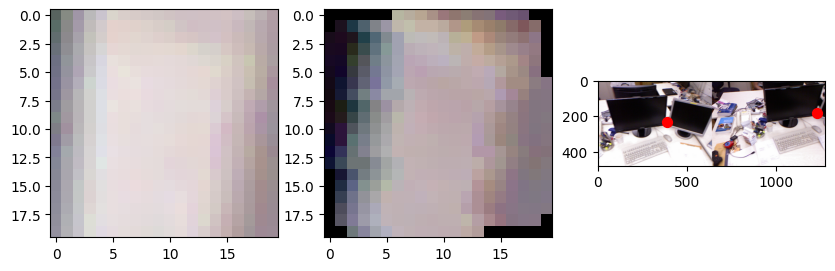

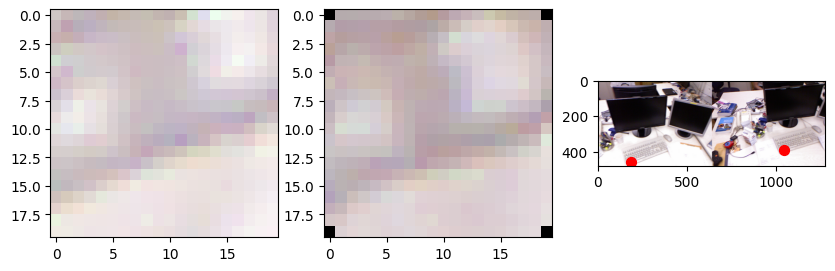

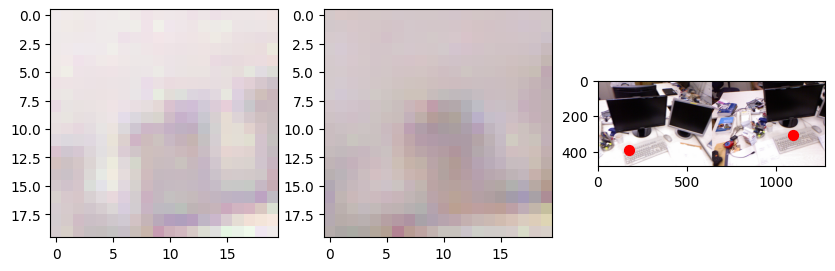

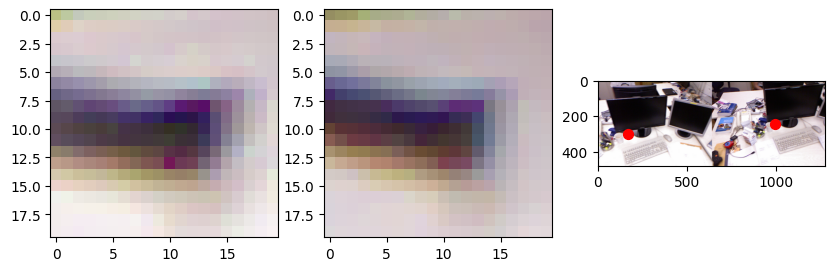

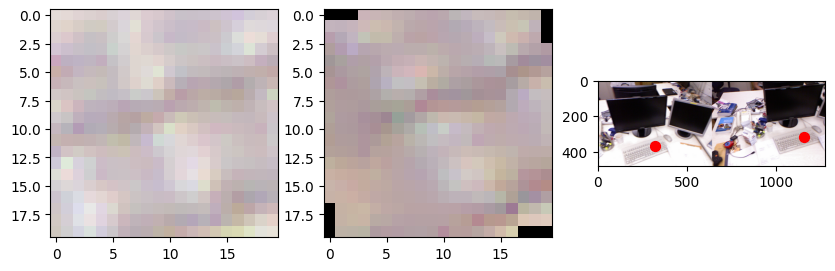

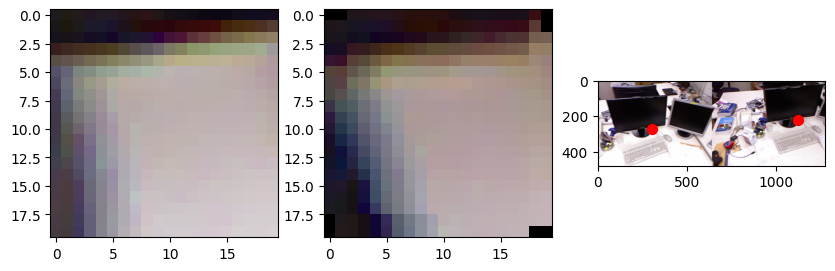

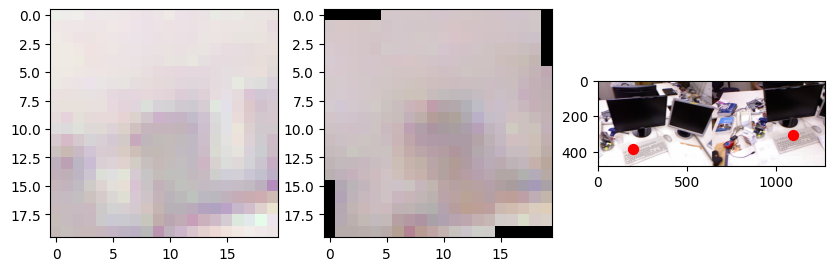

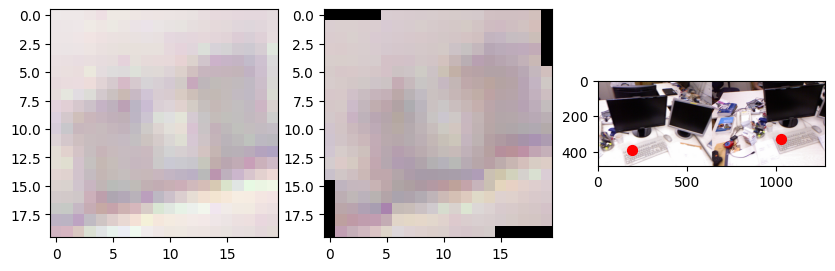

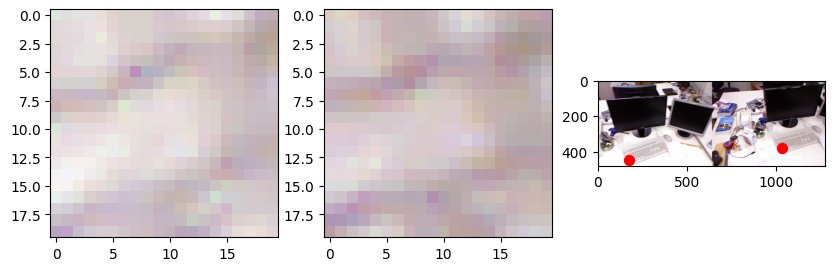

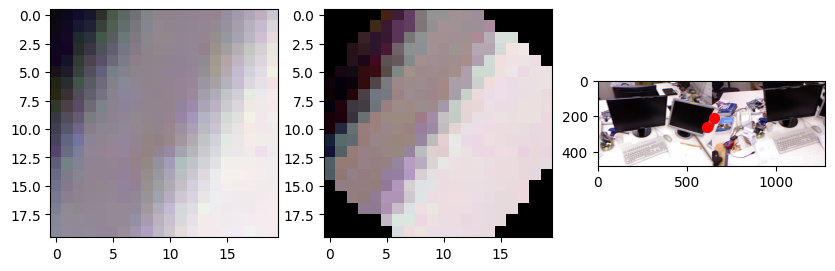

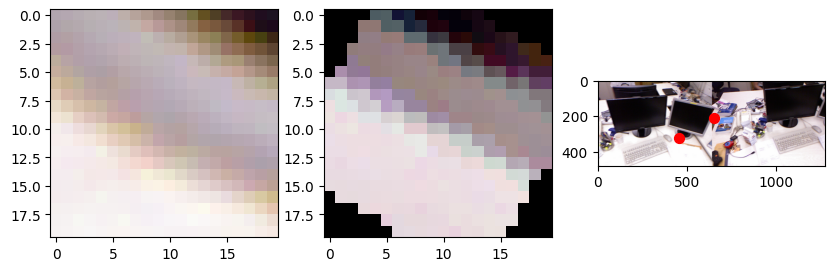

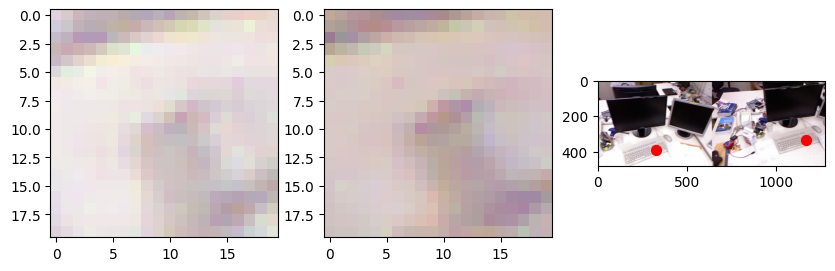

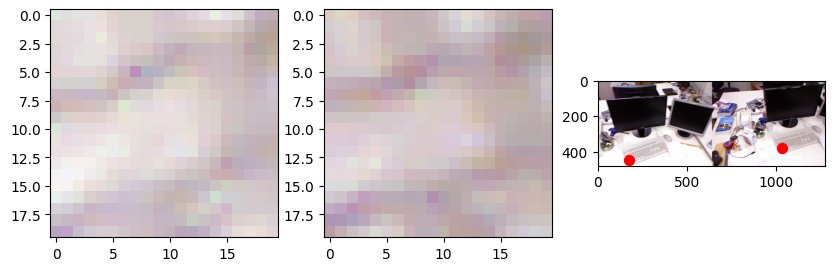

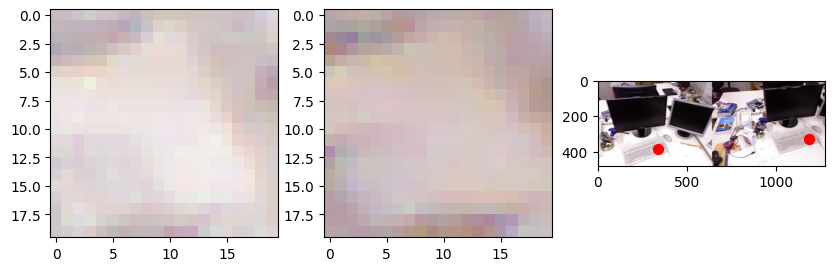

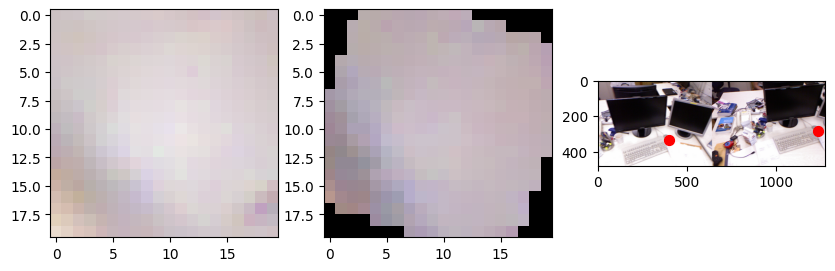

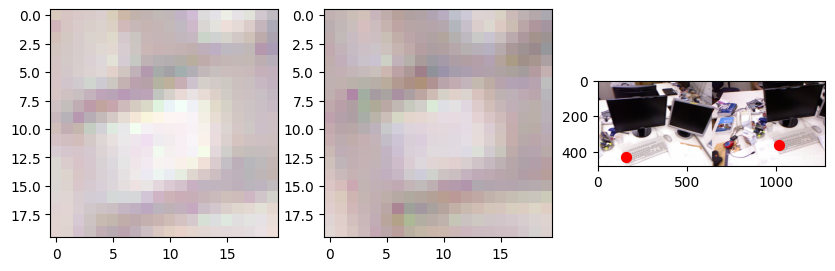

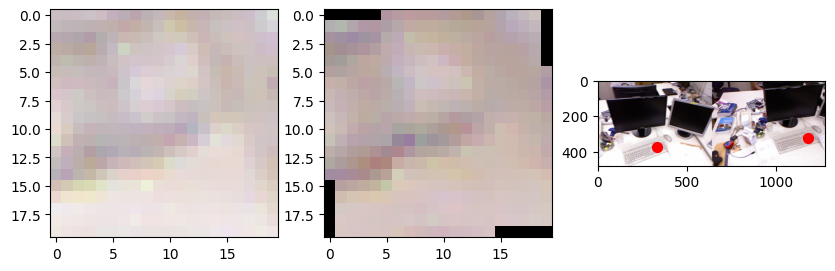

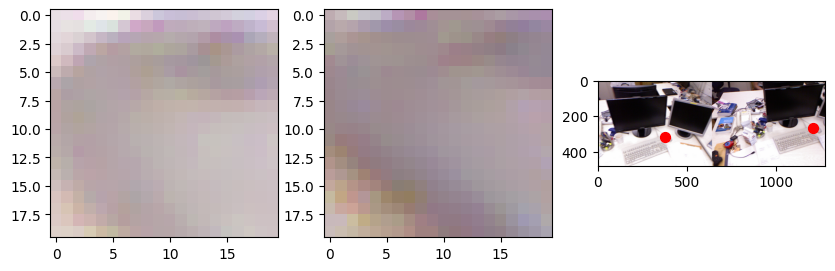

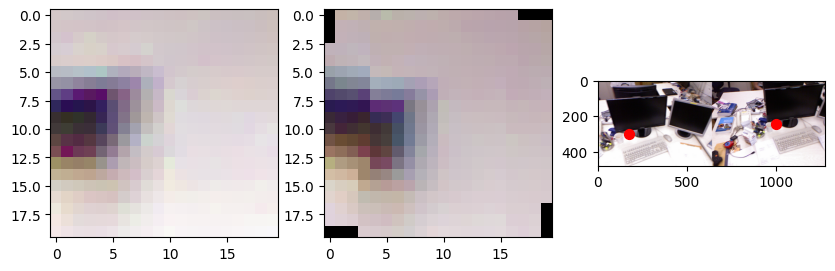

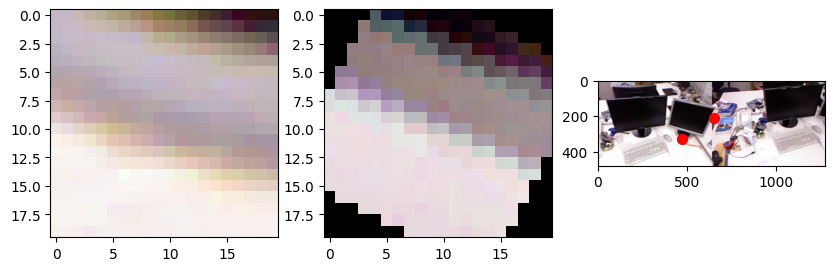

In [115]:
from PIL import Image




for i,j in zip(i0s, i1s):
    delta = 10
    # plt.imshow(rgb[0][])
    win0 = rgb[0][int(uv0[i,1])-delta:int(uv0[i,1])+delta, int(uv0[i,0])-delta:int(uv0[i,0])+delta]
    win1 = rgb[1][int(uv1[j,1])-delta:int(uv1[j,1])+delta, int(uv1[j,0])-delta:int(uv1[j,0])+delta]

    win0_ = Image.fromarray(win0).rotate(r0[i] - r0[i])
    win1_ = Image.fromarray(win1).rotate(r1[j] - r0[i])
    center1 = win1_.width // 2, win1_.height // 2
    win1_ = win1_.crop((center1[0]-delta, center1[1]-delta, center1[0]+delta, center1[1]+delta))

    fig, axs = plt.subplots(1,3, figsize=(10,5))
    axs[0].imshow(win0_)
    axs[1].imshow(win1_)
    axs[2].imshow(np.concatenate([rgb[0], rgb[1]], axis=1))
    axs[2].scatter([uv0[i,0], uv1[j,0]+rgb[0].shape[1]], [uv0[i,1], uv1[j,1]], s=50, c="r")

    # fig, axs = plt.subplots(1,2, figsize=(10,5))
    # axs[0].set_title(f"{r0[i]:0.1f}, {r1[j]:0.1f}")
    # axs[0].imshow(np.concatenate([win0, win1], axis=1))
    # axs[1].imshow(np.concatenate([rgb[0], rgb[1]], axis=1))
    # axs[1].scatter([uv0[i,0], uv1[j,0]+rgb[0].shape[1]], [uv0[i,1], uv1[j,1]], s=50, c="r")
    
# ==================
    
    # axs[1].imshow(convolved_image[0,0], alpha=0.5)

In [60]:
from b3d.camera import (
    camera_from_screen, 
    camera_from_screen_and_depth,
    screen_from_camera
)
from b3d.pose import Pose
from b3d.chisight.sfm.eight_point import (
    normalized_eight_point, 
    solve_epipolar_constraints,
    enforce_internal_constraint,
    normalize_hartley,
    poses_from_essential, 
    find_best_chirality,
    essential_from_pose,
    epipolar_errors,
    triangulate_linear_hartley
)

def _rescale_true(p, p_true):
    scale = jnp.linalg.norm(p_true.pos) / jnp.linalg.norm(p.pos)
    return Pose(scale * p.pos, p.quat)

rescale_true = jax.vmap(_rescale_true, in_axes=(0, None))

def plot_epi_lines(ax, E, ys0, cs, intr, zorder=10):
    for y,c in zip(ys0, cs):
        # Calculate the epipolar line in the second image
        ell = E@y[:,None]
        
        # Define points to plot the line (ax + by + c = 0)
        u = jnp.array([-10_000, 10_000])
        v = (-ell[2] - u*ell[0]) / ell[1]

        u0,v0 = screen_from_camera(jnp.array([u[0],v[0],1.]), intr)
        u1,v1 = screen_from_camera(jnp.array([u[1],v[1],1.]), intr)
        
        ax.plot([u0,u1], [v0,v1], c=c, zorder=zorder)

def xq_dist(p, p_):
    xerr = jnp.linalg.norm(p.pos-p_.pos)
    qerr = jnp.minimum(
        jnp.linalg.norm(p.quat - p_.quat),
        jnp.linalg.norm(p.quat + p_.quat)
    )
    return xerr, qerr

vmap_xq_dist = jax.vmap(xq_dist, (0,None))

def essential_matrix_constraint(E):
    """
    Computes the matrix contstraint `EE^T - 1/2 trace(EE^T)I = 0` for E to be an essential matrix.
    (https://en.wikipedia.org/wiki/Essential_matrix#Properties).
    """
    return E@E.T@E - 0.5*jnp.trace(E@E.T)*E


def val_from_im(uv, im):
    return im[uv[1].astype(jnp.int32), uv[0].astype(jnp.int32)]

vals_from_im = jax.vmap(val_from_im, in_axes=(0, None))


def reproject(uvs0, depth_im0, cam1, intr):
    """
    Reprojects a 3D point to a 2D point given the camera intrinsics
    """
    zs = vals_from_im(uvs0, jnp.array(depth_im0))
    xs = camera_from_screen_and_depth(uvs0, zs, intr)
    valid = zs > 0
    uvs1 = screen_from_camera(cam1.inv()(xs), intr)
    return uvs1, valid

In [61]:
p_true = cams[0].inv() @ cams[1]
E_true = essential_from_pose(p_true)
intr = data.get_intrinsics()

# ====================================
print(f"{xq_dist(p_true, Pose.id())}")

(Array(0.27544898, dtype=float32), Array(0.07768469, dtype=float32))


19


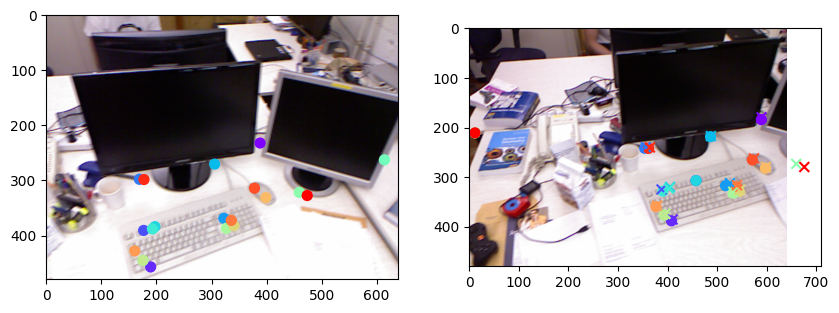

In [62]:
uv1_, valid = reproject(uv0[i0s], depth[0], p_true, intr)
print(valid.sum())
# ==================
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(rgb[0])
axs[0].scatter(uv0[i0s,0], uv0[i0s,1], s=50, c=jnp.linspace(0,1,len(i0s)), cmap="rainbow")
axs[1].imshow(rgb[1])
axs[1].scatter(uv1[i1s,0], uv1[i1s,1], s=50, c=jnp.linspace(0,1,len(i0s)),cmap="rainbow")
axs[1].scatter(uv1_[valid,0], uv1_[valid,1], 
               s=50, 
               c=jnp.linspace(0,1,len(i0s))[valid], vmax=1, vmin=0, 
               marker="x", cmap="rainbow")

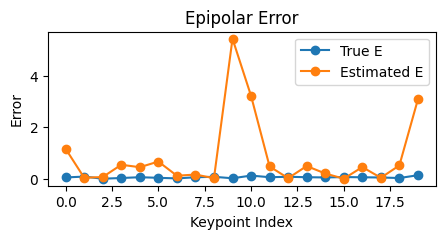

In [63]:
ys0 = camera_from_screen(uv0[i0s], intr)
ys1 = camera_from_screen(uv1[i1s], intr)
# ys0 = camera_from_screen(uv0[i0s][valid], intr)
# ys1 = camera_from_screen(uv1_[valid], intr)



E_norm = normalized_eight_point(ys0, ys1)

ys0 , T0 = normalize_hartley(ys0)
ys1 , T1 = normalize_hartley(ys1)
E = solve_epipolar_constraints(ys0 , ys1) 
E = enforce_internal_constraint(E)
E = T1.T @ E @ T0


ps = poses_from_essential(E)
ps = rescale_true(ps, p_true)

# ===================================
plt.figure(figsize=(5,2))
plt.title("Epipolar Error")
plt.plot(epipolar_errors(E_true, ys0, ys1), "o-", label="True E")
plt.plot(epipolar_errors(E, ys0, ys1), "o-", label="Estimated E")
plt.xlabel("Keypoint Index")
plt.ylabel("Error")
plt.legend()

0.27544898
[0.27544898 0.27544898 0.27544898 0.27544898]
[0.275449   0.27544895 0.275449   0.27544895]


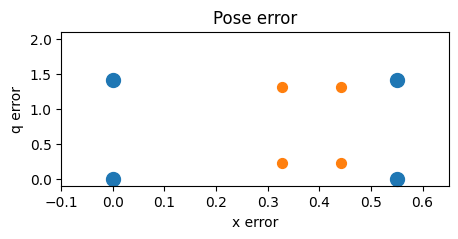

In [64]:
ps = rescale_true(poses_from_essential(E), p_true)
ps_true = rescale_true(poses_from_essential(E_true), p_true)

print(jnp.linalg.norm(p_true.pos))
print(jnp.linalg.norm(ps.pos, axis=-1))
print(jnp.linalg.norm(ps_true.pos, axis=-1))

# ===================================
plt.figure(figsize=(5,2))
plt.xlabel("x error")
plt.ylabel("q error")
plt.xlim(-.1, 2*jnp.linalg.norm(p_true.pos)+ 0.1)
plt.ylim(-.1, 2.1)
plt.title("Pose error")
plt.scatter(*vmap_xq_dist(ps_true, p_true), s=100, clip_on=False)
plt.scatter(*vmap_xq_dist(ps, p_true), s=50, clip_on=False)

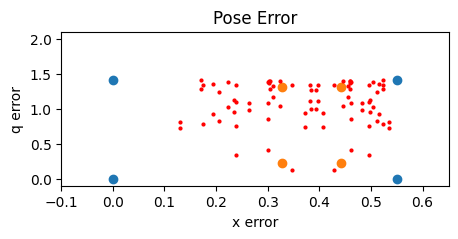

In [65]:
ps_true = rescale_true(poses_from_essential(E_true), p_true)

ys0 = camera_from_screen(uv0[i0s], intr)
ys1 = camera_from_screen(uv1[i1s], intr)

E = normalized_eight_point(ys0, ys1)
ps = rescale_true(poses_from_essential(E), p_true)
# ===================================
plt.figure(figsize=(5,2))
plt.xlabel("x error")
plt.ylabel("q error")
plt.xlim(-.1, 2*jnp.linalg.norm(p_true.pos)+ 0.1)
plt.ylim(-.1, 2.1)
plt.title("Pose Error")
plt.scatter(*vmap_xq_dist(ps_true, p_true), clip_on=False)
plt.scatter(*vmap_xq_dist(ps, p_true), clip_on=False)
for t in range(20):
    key, keys = keysplit(key, 1, 2)
    sig = 1.
    eps0 = jax.random.normal(keys[0], shape=ys0.shape, dtype=ys0.dtype) * sig
    eps1 = jax.random.normal(keys[1], shape=ys1.shape, dtype=ys1.dtype) * sig
    E = normalized_eight_point(ys0 + eps0, ys1 + eps1)
    ps = rescale_true(poses_from_essential(E), p_true)
    plt.scatter(*vmap_xq_dist(ps, p_true), clip_on=False, c="r", s=4)